### Setup for Google Colab

If you are running this notebook in Google Colab, complete the following steps:

1. In Colab, we recommend going to **Runtime → Change runtime type** and selecting **T4 GPU**
2. Install **TerraTorch** and the required packages
3. Download the dataset (as part of the notebook)

In [ ]:
!pip install terratorch==1.2.1
!pip install gdown tensorboard
!pip install -U jupyter ipywidgets

------------

## ForrestNet Data Tutorial

### Download and preprocess the dataset

In [ ]:
import shutil, zipfile, warnings, os
from pathlib import Path
from urllib.request import urlopen

import numpy as np
import pandas as pd
import rasterio as rio
from tqdm.auto import tqdm

warnings.filterwarnings("ignore")
DATA_URL = "http://download.cs.stanford.edu/deep/ForestNetDataset.zip"


def download_forestnet(data_dir: str) -> Path:
    data_dir = Path(data_dir)
    data_dir.mkdir(parents=True, exist_ok=True)

    zip_path, dataset_dir = data_dir / "ForestNetDataset.zip", data_dir / "ForestNetDataset"
    if dataset_dir.is_dir():
        return dataset_dir

    if not zip_path.exists():
        with urlopen(DATA_URL) as r, open(zip_path, "wb") as f:
            total = int(r.headers.get("Content-Length", 0))
            with tqdm(total=total, unit="B", unit_scale=True, desc=zip_path.name) as pbar:
                for chunk in iter(lambda: r.read(8192), b""):
                    f.write(chunk)
                    pbar.update(len(chunk))

    with zipfile.ZipFile(zip_path) as zf:
        zf.extractall(data_dir)
    
    extracted = data_dir / "deep" / "downloads" / "ForestNetDataset"
    if not extracted.is_dir():
        raise FileNotFoundError(f"Expected extracted folder not found: {extracted}")

    shutil.move(extracted, dataset_dir)
    zip_path.unlink(missing_ok=True)
    shutil.rmtree(data_dir / "deep", ignore_errors=True)
    return dataset_dir

def prepare_forestnet(data_dir: str = "data") -> Path:
    dataset_dir = download_forestnet(data_dir)
    tfm = rio.transform.from_bounds(0, 0, 332, 332, width=332, height=332)

    for split in ["train", "val", "test"]:
        examples = pd.read_csv(dataset_dir / f"{split}.csv")
        for c in sorted(examples["label"].unique()):
            (dataset_dir / split / c).mkdir(parents=True, exist_ok=True)

        for i, row in tqdm(examples.iterrows(), total=len(examples), desc=split):
            base = dataset_dir / row["example_path"] / "images"
            rgb_file = base / "visible" / "composite.png"
            ir_file = base / "infrared" / "composite.npy"
            if not (rgb_file.exists() and ir_file.exists()):
                continue

            with rio.open(rgb_file) as src:
                rgb = src.read()
            ir = np.load(ir_file)

            stacked = np.concatenate([rgb[[2, 1, 0]], ir.transpose((2, 0, 1))], axis=0)
            out_file = dataset_dir / split / row["label"] / f"{split}_{i}.tif"

            with rio.open(out_file, "w", driver="GTiff", height=332, width=332,
                          dtype=stacked.dtype, transform=tfm, count=6) as dst:
                dst.write(stacked)

    shutil.rmtree(dataset_dir / "examples", ignore_errors=True)
    print(f"Prepared ForestNet dataset at: {dataset_dir}")

prepare_forestnet()

In [2]:
import os

DATASET_PATH = os.path.join("data", "ForestNetDataset")

# Ensure the dataset is available
assert os.path.isdir(os.path.join(DATASET_PATH, "val")), (
    "ForestNetDataset not found. Please run the dataset preparation step first."
)

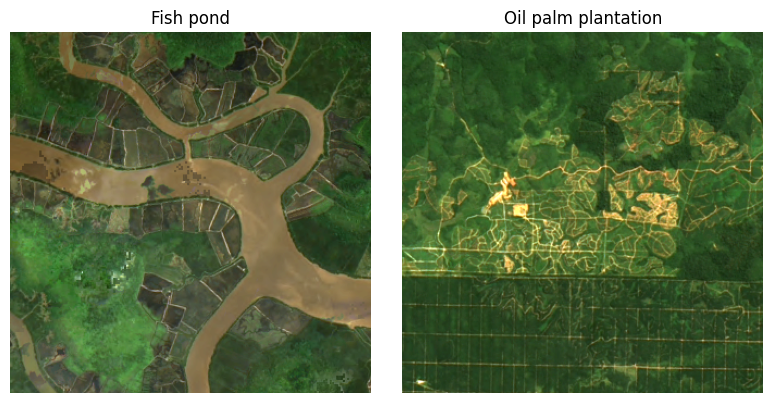

In [3]:
# Visualize a few samples
import matplotlib.pyplot as plt
import rioxarray as rxr

samples = [
    "data/ForestNetDataset/train/Fish pond/train_153.tif",
    "data/ForestNetDataset/train/Oil palm plantation/train_9.tif",
]

fig, axes = plt.subplots(1, 2, figsize=(8, 4))

for ax, path in zip(axes, samples):
    label = os.path.basename(os.path.dirname(path))
    img = (
        rxr.open_rasterio(path)
        .sel(band=[3, 2, 1])
        .transpose("y", "x", "band")
        .to_numpy()
        * 3
    ).clip(0,255)
    
    ax.imshow(img)
    ax.set_title(label)
    ax.axis("off")

plt.tight_layout()
plt.show()

### Build datamodule

In [5]:
import albumentations as A
from terratorch.datamodules import GenericNonGeoClassificationDataModule

# HLS pre-training statistics (6 bands)
MEANS = [775.229, 1080.992, 1228.585, 2497.202, 2204.213, 1610.832]
STDS  = [1281.526, 1270.029, 1399.480, 1368.344, 1291.676, 1154.505]

# Crop to 224×224
train_transforms = A.Compose([
    A.RandomCrop(height=224, width=224),
    A.HorizontalFlip(),
    A.pytorch.transforms.ToTensorV2()
])

val_transforms = A.Compose([
    A.CenterCrop(height=224, width=224),
    A.pytorch.transforms.ToTensorV2()
])

datamodule = GenericNonGeoClassificationDataModule(
    batch_size=16,
    num_workers=0,
    train_data_root=os.path.join(DATASET_PATH, "train"),
    val_data_root=os.path.join(DATASET_PATH, "val"),
    test_data_root=os.path.join(DATASET_PATH, "test"),
    means=MEANS,
    stds=STDS,
    num_classes=12,
    # Albumentations transforms can be passed directly
    train_transform=train_transforms,
    val_transform=val_transforms,
    test_transform=val_transforms,
    constant_scale=39.216,  # scale 0–255 data to ~0–10000 (HLS scale)
    no_data_replace=0,
)

### Initialize the task module

In [6]:
from terratorch.tasks import ClassificationTask

model_args = {
    "backbone": "vit_base_patch16_224.mae",
    "in_channels": 6,
    "num_classes": 12,
    "pretrained": True,
}

task = ClassificationTask(
    model_factory="TimmModelFactory",
    model_args=model_args,
    loss="ce",
    optimizer="AdamW",
    optimizer_hparams={"weight_decay": 0.05},
    lr=1e-4,
    ignore_index=-1,
    freeze_backbone=True,
)

### Initialize trainer and start training

In [ ]:
from lightning.pytorch import Trainer
from lightning.pytorch.callbacks import ModelCheckpoint, RichProgressBar
from lightning.pytorch.loggers import TensorBoardLogger

checkpoint = ModelCheckpoint(monitor=task.monitor, save_top_k=1, save_last=True)
logger = TensorBoardLogger(save_dir="output", name="tutorial")

trainer = Trainer(
    devices=1,
    precision="16-mixed",
    max_epochs=1,  # demo only
    callbacks=[RichProgressBar(), checkpoint],
    logger=logger,
    default_root_dir="output/tutorial",
    log_every_n_steps=1,
)

_ = trainer.fit(task, datamodule)

## Fine-tuning via CLI

Before running the CLI examples, it can be helpful to restart the session to free up GPU memory.

In [ ]:
!terratorch fit -c forestnet_dataset_timm_model.yaml